In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load datasets
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')
customers_df = pd.read_csv('Customers.csv')


In [3]:
#merging datasets for analysis
merged_df = transactions_df.merge(products_df, on="ProductID").merge(customers_df, on="CustomerID")

In [4]:
print(merged_df)

    TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0          T00001      C0199      P067  2024-08-25 12:38:23         1   
1          T00112      C0146      P067  2024-05-27 22:23:54         1   
2          T00166      C0127      P067  2024-04-25 07:38:55         1   
3          T00272      C0087      P067  2024-03-26 22:55:37         2   
4          T00363      C0070      P067  2024-03-21 15:10:10         3   
..            ...        ...       ...                  ...       ...   
995        T00496      C0118      P037  2024-10-24 08:30:27         1   
996        T00759      C0059      P037  2024-06-04 02:15:24         3   
997        T00922      C0018      P037  2024-04-05 13:05:32         4   
998        T00959      C0115      P037  2024-09-29 10:16:02         2   
999        T00992      C0024      P037  2024-04-21 10:52:24         1   

     TotalValue  Price_x                      ProductName     Category  \
0        300.68   300.68  ComfortLiving Bluetooth

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   ProductName      1000 non-null   object 
 8   Category         1000 non-null   object 
 9   Price_y          1000 non-null   float64
 10  CustomerName     1000 non-null   object 
 11  Region           1000 non-null   object 
 12  SignupDate       1000 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB


In [6]:
merged_df.isnull().sum()

,0
TransactionID,0
CustomerID,0
ProductID,0
TransactionDate,0
Quantity,0
TotalValue,0
Price_x,0
ProductName,0
Category,0
Price_y,0


In [7]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1000.0,2.53700,1.117981,1.00,2.000,3.00,4.00,4.00
TotalValue,1000.0,689.99556,493.144478,16.08,295.295,588.88,1011.66,1991.04
Price_x,1000.0,272.55407,140.736390,16.08,147.950,299.93,404.40,497.76
Price_y,1000.0,272.55407,140.736390,16.08,147.950,299.93,404.40,497.76


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
# Prepare customer profile dataset
customer_profile = merged_df.groupby("CustomerID").agg({
    "Region": "first",
    "TotalValue": "sum",
    "Quantity": "sum",
    "Category": lambda x: x.mode()[0]
}).reset_index()

In [10]:
 #Encode categorical features
customer_profile = pd.get_dummies(customer_profile, columns=["Region", "Category"], drop_first=True)

In [11]:
# Standardize numerical columns
scaler = StandardScaler()
customer_profile[["TotalValue", "Quantity"]] = scaler.fit_transform(customer_profile[["TotalValue", "Quantity"]])


In [12]:
customer_profile.to_csv('final_data.csv', index=False)
customer_profile.head()

,CustomerID,TotalValue,Quantity,Region_Europe,Region_North America,Region_South America,Category_Clothing,Category_Electronics,Category_Home Decor
0,C0001,-0.061701,-0.122033,False,False,True,False,True,False
1,C0002,-0.877744,-0.448000,False,False,False,True,False,False
2,C0003,-0.405857,0.203934,False,False,True,False,False,True
3,C0004,1.032547,1.670787,False,False,True,False,False,False
4,C0005,-0.783929,-0.936951,False,False,False,False,True,False


In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [14]:
# Prepare dataset for clustering
clustering_data = customer_profile.drop(columns=["CustomerID", "Similarity"], errors='ignore')

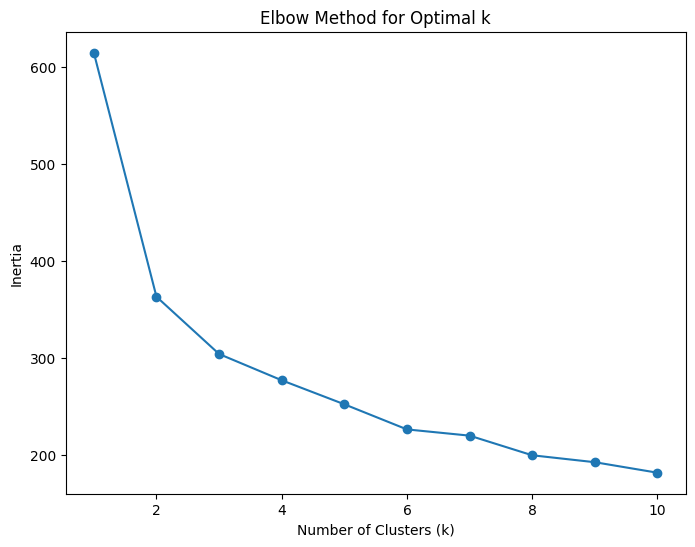

In [15]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [16]:
# Prepare dataset for clustering
clustering_data = customer_profile.drop(columns=["CustomerID", "Similarity"], errors='ignore')

kmeans = KMeans(n_clusters=5, random_state=42)
customer_profile["Cluster"] = kmeans.fit_predict(clustering_data)
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(clustering_data, customer_profile["Cluster"])
print("Davies-Bouldin Index:", db_index)

Davies-Bouldin Index: 1.4764601048668444


<Figure size 1600x1200 with 0 Axes>

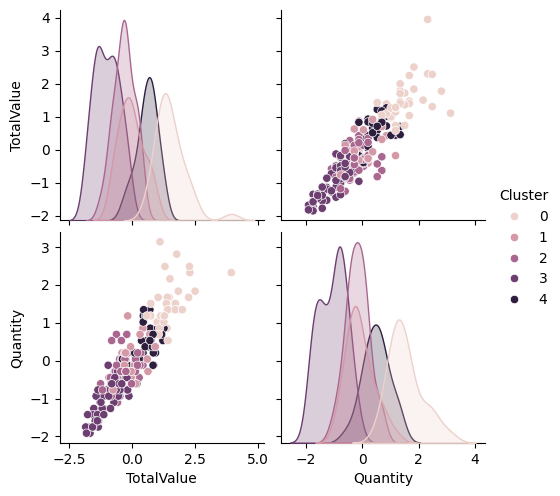

In [17]:
# Pairplot for visualizing relationships between variables and clusters
plt.figure(figsize=(16,12))
sns.pairplot(customer_profile, hue="Cluster", vars=["TotalValue", "Quantity"])
plt.show()

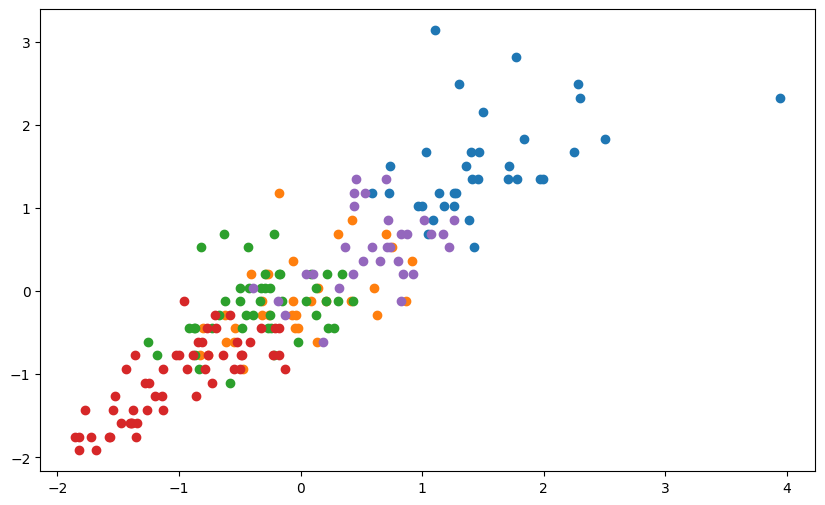

In [18]:
#Visualize centroids in 2D space (if relevant)
plt.figure(figsize=(10, 6))
for cluster_id in range(kmeans.n_clusters):
    plt.scatter(
        clustering_data[customer_profile["Cluster"] == cluster_id]["TotalValue"],
        clustering_data[customer_profile["Cluster"] == cluster_id]["Quantity"],
        label=f"Cluster {cluster_id}"
    )

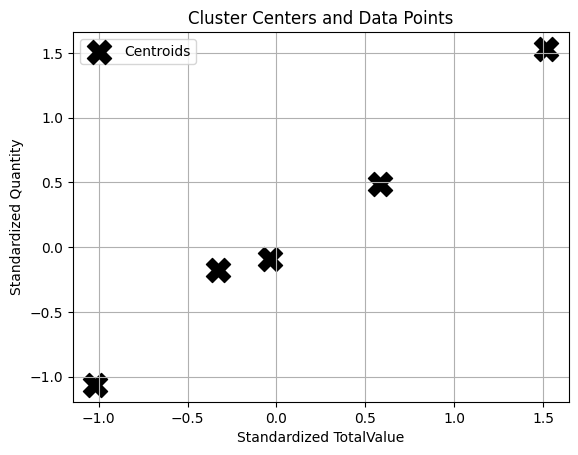

In [19]:

# Overlay centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c="black", marker="X", label="Centroids")
plt.title("Cluster Centers and Data Points")
plt.xlabel("Standardized TotalValue")
plt.ylabel("Standardized Quantity")
plt.legend()
plt.grid()
plt.show()